In [1]:
import pandas as pd
import numpy as np
import kaggle
import os
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

%matplotlib inline

In [12]:
kaggle.api.authenticate()
kaggle.api.competition_download_files('titanic', path='./titanic_data')

with zipfile.ZipFile('./titanic_data/titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('./titanic_data')

os.remove('./titanic_data/titanic.zip')

In [13]:
train_df = pd.read_csv('./titanic_data/train.csv')
test_df = pd.read_csv('./titanic_data/test.csv')

In [14]:
train_df = train_df[['Survived', 'Pclass', 'Sex', 'Fare']]

train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})

train_df.head(10)

,Survived,Pclass,Sex,Fare
0,0,3,0,7.2500
1,1,1,1,71.2833
2,1,3,1,7.9250
3,1,1,1,53.1000
4,0,3,0,8.0500
5,0,3,0,8.4583
6,0,1,0,51.8625
7,0,3,0,21.0750
8,1,3,1,11.1333
9,1,2,1,30.0708


---

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier()
parametrs = {
    'n_estimators': [i for i in range(1, 16)],  
    'max_depth': [i for i in range(1, 11)]  
}

x_train = train_df[['Pclass', 'Sex', 'Fare']]
y_train = train_df.Survived


grid_search_cv_clf = GridSearchCV(clf_rf, parametrs, cv=5)
grid_search_cv_clf.fit(x_train, y_train)
grid_search_cv_clf.best_params_

{'max_depth': 6, 'n_estimators': 7}

In [16]:
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
x_test = test_df[['Pclass', 'Sex', 'Fare']]

In [17]:
# Получить предсказания и вероятности
predictions = grid_search_cv_clf.predict(x_test)
probabilities = grid_search_cv_clf.predict_proba(x_test)

# Создать полный DataFrame с результатами
results_df = test_df.copy()  # Копируем исходные признаки из тестовой выборки

# Добавить предсказания
results_df['Prediction'] = predictions

# Добавить вероятности для каждого класса
results_df['Prob_Not_Survived'] = probabilities[:, 0]  # Вероятность класса 0 (не выжил)
results_df['Prob_Survived'] = probabilities[:, 1]      # Вероятность класса 1 (выжил)

In [19]:
results_df[['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'Fare', 'Prediction', 'Prob_Not_Survived', 'Prob_Survived']].head(20)

,PassengerId,Pclass,Name,Sex,Age,Fare,Prediction,Prob_Not_Survived,Prob_Survived
0,892,3,"Kelly, Mr. James",0,34.5,7.8292,0,0.867490,0.132510
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.0,7.0000,1,0.288396,0.711604
2,894,2,"Myles, Mr. Thomas Francis",0,62.0,9.6875,0,0.877873,0.122127
3,895,3,"Wirz, Mr. Albert",0,27.0,8.6625,0,0.843055,0.156945
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.0,12.2875,1,0.276062,0.723938
5,897,3,"Svensson, Mr. Johan Cervin",0,14.0,9.2250,0,0.843055,0.156945
6,898,3,"Connolly, Miss. Kate",1,30.0,7.6292,1,0.311611,0.688389
7,899,2,"Caldwell, Mr. Albert Francis",0,26.0,29.0000,0,0.632153,0.367847
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18.0,7.2292,1,0.154468,0.845532
9,901,3,"Davies, Mr. John Samuel",0,21.0,24.1500,0,0.872694,0.127306


In [20]:
# Лучший score на кросс-валидации
print("Лучший CV score:", grid_search_cv_clf.best_score_)

Лучший CV score: 0.8148452702278576


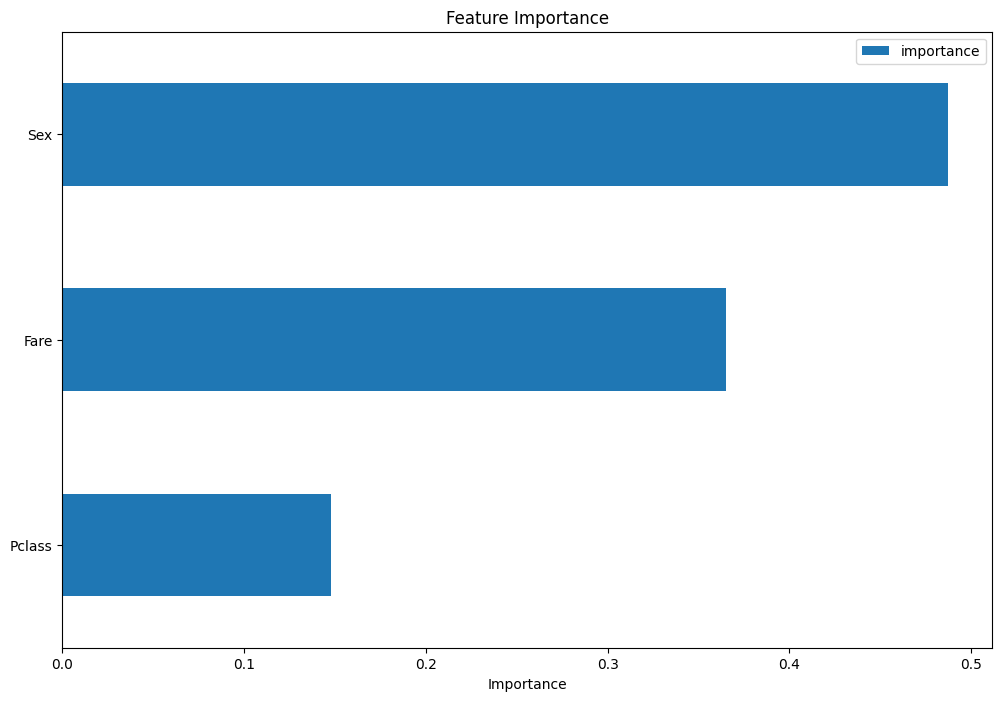

In [25]:
import matplotlib.pyplot as plt

best_model = grid_search_cv_clf.best_estimator_

imp = pd.DataFrame(best_model.feature_importances_,
                   index=x_train.columns,
                   columns=['importance'])

imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.show()

---

In [26]:
import shutil

folder_path = './titanic_data'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Folder {folder_path} succeful delited")
else:
    print(f"Folder {folder_path} does not exist")

Folder ./titanic_data succeful delited
